In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
import numpy as np
import pandas as pd
from typing import List, Tuple

import matplotlib.pyplot as plt

https://en.wikipedia.org/wiki/Decision_tree

In [9]:
# ALL FEATURES NUMERICAL

# Decision Tree

In [157]:
class DecisionTree():

    def __init__(self, max_depth = 1000, min_samples_split = 2, n_features = None, n_split = None):
        self.root = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
        # for random forest
        # self.n_features = n_features
        # self.n_split = n_split
    
    
    class Node():
        def __init__(self, feature_index_col: int, threshold: float, left: "DecisionTree.Node", right: "DecisionTree.Node", majority_class):
            self.feature_index_col = feature_index_col
            self.threshold = threshold
            self.left = left
            self.right = right
            self.majority_class = majority_class # if a node is cut off due to max depth or size constraint, this becomes useful. also works for purity. 
            
        def predict(self, x: np.ndarray):
            if self.feature_index_col is None or self.threshold is None: # leaf node
                return self.majority_class
            else:
                # print(self.feature_index_col, self.threshold, x[self.feature_index_col])
                if x[self.feature_index_col] <= self.threshold:
                    return self.left.predict(x)
                else:
                    return self.right.predict(x)
    
    
    def entropy(self, y: np.ndarray):
        values, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        entropy = - (probs * np.log2(probs)).sum()
        return entropy
    
    
    def information_gain(self, X_col: np.ndarray, y: np.ndarray, threshold: float) -> float:
        left_mask = X_col <= threshold # by convention left node meets condition
        right_mask = ~left_mask
        left_y = y[left_mask]
        right_y = y[right_mask]
        left_entropy = self.entropy(left_y)
        right_entropy = self.entropy(right_y)
        left_prob = left_y.shape[0] / y.shape[0]
        right_prob = right_y.shape[0] / y.shape[0]
        weighted_average_entropy = left_prob * left_entropy + right_prob * right_entropy
        
        total_entropy = self.entropy(y)
        return total_entropy - weighted_average_entropy
    
    
    def find_all_feature_split_rules(self, X: np.ndarray) -> List[np.ndarray]:
        all_feature_split_rules = []
        for feature_col in X.T:
            unique_values = np.unique(feature_col) # also sorts values
            unique_values_midpoints = (unique_values[:-1] + unique_values[1:]) / 2
            all_feature_split_rules.append(unique_values_midpoints)
        return all_feature_split_rules

    
    def find_best_split(self, X: np.ndarray, y: np.ndarray, all_feature_split_rules: List[np.ndarray]) -> Tuple[int, float]:
        features_best_splits = [] # for each feature track what was the best split
        for index, feature_split_rules in enumerate(all_feature_split_rules):
            X_col = X[:, index]
            feature_best_split = (index, None, -1e9) # index, threshold, infogain
            for threshold in feature_split_rules:
                infogain = self.information_gain(X_col, y, threshold)
                if infogain > feature_best_split[2]:
                    feature_best_split = (index, threshold, infogain)
            features_best_splits.append(feature_best_split)
        
        # find the best split across features
        col_index, threshold, infogain = max(features_best_splits, key=lambda x: x[2])
        
        # if threshold is None: # happens when dataset has same X, but different Y.
        #     print('threshold is None')
        #     print(all_feature_split_rules)
        #     print(X, y)
            
        return col_index, threshold
    
    
    def build_tree(self, X: np.ndarray, y: np.ndarray, current_depth: int = 1):
    
        values, counts = np.unique(y, return_counts=True)
        majority_class = values[np.argmax(counts)]
        # base cases: max depth exceeded, node too small, or pure node
        if current_depth > self.max_depth or X.shape[0] < self.min_samples_split or len(np.unique(y)) == 1: 
            return DecisionTree.Node(None, None, None, None, majority_class)
        
        index_col, threshold = self.find_best_split(X, y, self.find_all_feature_split_rules(X))
        
        if threshold is None: # happens when X is all same value with different y
            return DecisionTree.Node(None, None, None, None, majority_class)
        
        # print(index_col, threshold)
        X_left = X[X[:, index_col] <= threshold]
        y_left = y[X[:, index_col] <= threshold]
        X_right = X[X[:, index_col] > threshold]
        y_right = y[X[:, index_col] > threshold]
        
        # last node created is the root
        left_node = self.build_tree(X_left, y_left, current_depth + 1)
        right_node = self.build_tree(X_right, y_right, current_depth + 1)
        
        return DecisionTree.Node(index_col, threshold, left_node, right_node, majority_class)
    
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        self.root = self.build_tree(X, y)
        return self
    
            
    def predict(self, dataset: np.ndarray):
        result = []
        for datapoint in dataset:
            result.append(self.root.predict(datapoint))
        return np.array(result)
    

In [1]:
import pandas as pd
url_Wine = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
wine = pd.read_csv(url_Wine, delimiter=';')
X = wine.drop(columns=["quality"]).to_numpy()
y = wine["quality"].to_numpy()

In [22]:
X_np = X.to_numpy()
y_np = y.to_numpy()

In [23]:
split_rules = []
for feature_col in X_np.T:
    unique_values = np.unique(feature_col) # sorts unique values
    unique_values_midpoints = (unique_values[:-1] + unique_values[1:]) / 2
    split_rules.append(unique_values_midpoints)
    
split_rules

[array([ 4.65,  4.8 ,  4.95,  5.05,  5.15,  5.25,  5.35,  5.45,  5.55,
         5.65,  5.75,  5.85,  5.95,  6.05,  6.15,  6.25,  6.35,  6.45,
         6.55,  6.65,  6.75,  6.85,  6.95,  7.05,  7.15,  7.25,  7.35,
         7.45,  7.55,  7.65,  7.75,  7.85,  7.95,  8.05,  8.15,  8.25,
         8.35,  8.45,  8.55,  8.65,  8.75,  8.85,  8.95,  9.05,  9.15,
         9.25,  9.35,  9.45,  9.55,  9.65,  9.75,  9.85,  9.95, 10.05,
        10.15, 10.25, 10.35, 10.45, 10.55, 10.65, 10.75, 10.85, 10.95,
        11.05, 11.15, 11.25, 11.35, 11.45, 11.55, 11.65, 11.75, 11.85,
        11.95, 12.05, 12.15, 12.25, 12.35, 12.45, 12.55, 12.65, 12.75,
        12.85, 12.95, 13.1 , 13.25, 13.35, 13.45, 13.6 , 13.75, 13.9 ,
        14.15, 14.65, 15.25, 15.55, 15.75]),
 array([0.14  , 0.17  , 0.185 , 0.195 , 0.205 , 0.215 , 0.225 , 0.235 ,
        0.245 , 0.255 , 0.265 , 0.275 , 0.285 , 0.2925, 0.2975, 0.3025,
        0.3075, 0.3125, 0.3175, 0.325 , 0.335 , 0.345 , 0.355 , 0.3625,
        0.3675, 0.375 , 0.385

In [37]:
def find_splits(X: np.ndarray) -> List[np.ndarray]:
    split_rules = []
    for feature_col in X.T:
        unique_values = np.unique(feature_col) # sorts unique values
        unique_values_midpoints = (unique_values[:-1] + unique_values[1:]) / 2
        split_rules.append(unique_values_midpoints)
    return split_rules

In [33]:
values, counts = np.unique(y_np, return_counts=True)
probs = counts / counts.sum()
entropy = - (probs * np.log2(probs)).sum()
entropy

1.7090616375059242

In [62]:
def entropy(y: np.ndarray):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    entropy = - (probs * np.log2(probs)).sum()
    return entropy

In [49]:
# Test case 1: All elements are of the same class
test_case_1 = np.array([0, 0, 0, 0, 0])
print(entropy(test_case_1)) # Expected output: 0.0
# Test case 2: Elements are evenly split between two classes
test_case_2 = np.array([0, 1, 0, 1, 0, 1])
print(entropy(test_case_2)) # Expected output: 1.0
# Test case 3: Elements are unevenly split between two classes
test_case_3 = np.array([0, 0, 0, 1, 1])
print(entropy(test_case_3)) # Expected output: 0.971
# Test case 4: Only one element
test_case_4 = np.array([0])
print(entropy(test_case_4)) # Expected output: 0.0

-0.0
1.0
0.9709505944546686
-0.0


In [61]:
def information_gain(X_col: np.ndarray, y: np.ndarray, threshold: float) -> float:
    left_mask = X_col <= threshold # by convention left node meets condition
    right_mask = ~left_mask
    left_y = y[left_mask]
    right_y = y[right_mask]
    left_entropy = entropy(left_y)
    right_entropy = entropy(right_y)
    left_prob = left_y.shape[0] / y.shape[0]
    right_prob = right_y.shape[0] / y.shape[0]
    weighted_average_entropy = left_prob * left_entropy + right_prob * right_entropy
    
    total_entropy = entropy(y)
    return total_entropy - weighted_average_entropy
    

In [21]:

for index, feature_split_rules in enumerate(split_rules):
    X_col = X_np[:, index]
    for splitting_rule in feature_split_rules:
        left_mask = X_col <= splitting_rule # by convention left node meets condition
        right_mask = ~left_mask
        left_y = y_np[left_mask]
        right_y = y_np[right_mask]
        
        left_entropy = entropy(left_y)
        right_entropy = entropy(right_y)

[ 4.65  4.8   4.95  5.05  5.15  5.25  5.35  5.45  5.55  5.65  5.75  5.85
  5.95  6.05  6.15  6.25  6.35  6.45  6.55  6.65  6.75  6.85  6.95  7.05
  7.15  7.25  7.35  7.45  7.55  7.65  7.75  7.85  7.95  8.05  8.15  8.25
  8.35  8.45  8.55  8.65  8.75  8.85  8.95  9.05  9.15  9.25  9.35  9.45
  9.55  9.65  9.75  9.85  9.95 10.05 10.15 10.25 10.35 10.45 10.55 10.65
 10.75 10.85 10.95 11.05 11.15 11.25 11.35 11.45 11.55 11.65 11.75 11.85
 11.95 12.05 12.15 12.25 12.35 12.45 12.55 12.65 12.75 12.85 12.95 13.1
 13.25 13.35 13.45 13.6  13.75 13.9  14.15 14.65 15.25 15.55 15.75]
[0.14   0.17   0.185  0.195  0.205  0.215  0.225  0.235  0.245  0.255
 0.265  0.275  0.285  0.2925 0.2975 0.3025 0.3075 0.3125 0.3175 0.325
 0.335  0.345  0.355  0.3625 0.3675 0.375  0.385  0.3925 0.3975 0.405
 0.4125 0.4175 0.425  0.435  0.445  0.455  0.465  0.4725 0.4775 0.485
 0.495  0.505  0.515  0.525  0.535  0.5425 0.5475 0.555  0.5625 0.5675
 0.5725 0.5775 0.5825 0.5875 0.5925 0.5975 0.6025 0.6075 0.6125 0.6175


In [81]:
# finding best split
all_feature_split_rules = split_rules

def find_best_split(X: np.ndarray, y: np.ndarray, all_feature_split_rules: List[np.ndarray]) -> Tuple[int, float]:
    
    features_best_splits = []
    for index, feature_split_rules in enumerate(all_feature_split_rules):
        X_col = X[:, index]
        feature_best_split = (index, None, -1e9) # index, threshold, infogain
        for threshold in feature_split_rules:
            infogain = information_gain(X_col, y, threshold)
            if infogain > feature_best_split[2]:
                feature_best_split = (index, threshold, infogain)
        features_best_splits.append(feature_best_split)
        
    col_index, threshold, infogain = max(features_best_splits, key=lambda x: x[2])
    return col_index, threshold

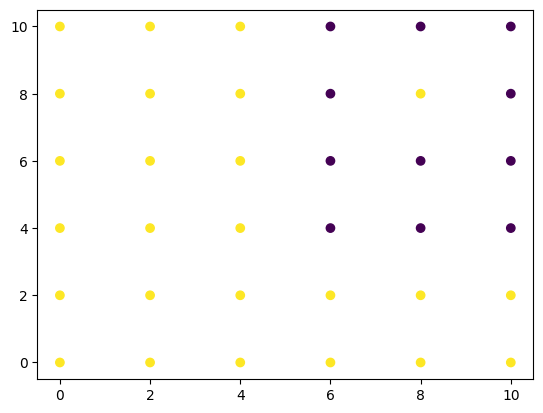

In [33]:
# creating a test dataset
# really does help to narrow down where bugs are festering
dataset = np.array([
    [0, 0, 1],
    [0, 2, 1],
    [0, 4, 1],
    [0, 6, 1],
    [0, 8, 1],
    [0, 10, 1],
    
    
    [2, 0, 1],
    [2, 2, 1],
    [2, 4, 1],
    [2, 6, 1],
    [2, 8, 1],
    [2, 10, 1],

    [4, 0, 1],
    [4, 2, 1],
    [4, 4, 1],
    [4, 6, 1],
    [4, 8, 1],
    [4, 10, 1],
    
    [6, 0, 1],
    [6, 2, 1],
    [6, 4, 0],
    [6, 6, 0],
    [6, 8, 0],
    [6, 10, 0],
    
    [8, 0, 1],
    [8, 2, 1],
    [8, 4, 0],
    [8, 6, 0],
    # [8, 8, 0],
    [8, 8, 1], # testing max depth. this point adds like 4 more splits
    [8, 10, 0],
    
    
    [10, 0, 1],
    [10, 2, 1],
    [10, 4, 0],
    [10, 6, 0],
    [10, 8, 0],
    [10, 10, 0],
    
])
X = dataset[:, :-1]
y = dataset[:, -1]

# all_feature_split_rules = find_splits(X)
# best_split = find_best_split(X, y, all_feature_split_rules)
# print(best_split)

plt.scatter(dataset[:, 0], dataset[:, 1], c=dataset[:, 2], cmap='viridis')

In [94]:
# i guess that you have to run this recursively
# base caeses. pure node or max depth reached. 
# for a given set of data, that could've already been split
# calculate the next best split

# so first go through and build out the splits without worrying about tracking things for prediction

# verbose for debugging

max_depth = 4
def build_tree(X: np.ndarray, y: np.ndarray, current_depth: int = 1):
    
    if current_depth > max_depth: # max depth exceeded
        return
    if len(np.unique(y)) == 1: # pure node
        return
    
    index_col, threshold = find_best_split(X, y, find_splits(X))
    print(index_col, threshold)
    X_left = X[X[:, index_col] <= threshold]
    y_left = y[X[:, index_col] <= threshold]
    X_right = X[X[:, index_col] > threshold]
    y_right = y[X[:, index_col] > threshold]
    
    build_tree(X_left, y_left, current_depth + 1)
    build_tree(X_right, y_right, current_depth + 1)

In [128]:
root = build_tree(X, y)

0 5.0
1 3.0
1 7.0
1 9.0
0 7.0
0 9.0


In [131]:
root.predict([7.0, 8])

0 5.0 7.0
1 3.0 8
1 7.0 8
1 9.0 8
0 7.0 7.0


0

In [78]:
# so all of the right computations are being performed. 
# now i need to store the results so that they can be used for prediction
# creating nodes that use feature and threshold
# nodes need left and right child nodes

class Node():
    def __init__(self, feature_index_col: int, threshold: float, left: "Node", right: "Node", majority_class):
        self.feature_index_col = feature_index_col
        self.threshold = threshold
        self.left = left
        self.right = right
        self.majority_class = majority_class # if a node is cut off due to max depth, this becomes useful. also works for purity base case. 
        
    def predict(self, x):
        if self.feature_index_col is None or self.threshold is None: # check leaf node
            return self.majority_class
        else:
            print(self.feature_index_col, self.threshold, x[self.feature_index_col])
            if x[self.feature_index_col] <= self.threshold:
                return self.left.predict(x)
            else:
                return self.right.predict(x)

max_depth = 7
def build_tree(X: np.ndarray, y: np.ndarray, current_depth: int = 1):
    
    values, counts = np.unique(y, return_counts=True)
    majority_class = values[np.argmax(counts)]
    if current_depth > max_depth or len(np.unique(y)) == 1: # max depth exceeded or pure node
        return Node(None, None, None, None, majority_class)
    
    index_col, threshold = find_best_split(X, y, find_splits(X))
    print(index_col, threshold)
    X_left = X[X[:, index_col] <= threshold]
    y_left = y[X[:, index_col] <= threshold]
    X_right = X[X[:, index_col] > threshold]
    y_right = y[X[:, index_col] > threshold]
    
    # last node created is the root (dfs)
    left_node = build_tree(X_left, y_left, current_depth + 1)
    right_node = build_tree(X_right, y_right, current_depth + 1)
    
    return Node(index_col, threshold, left_node, right_node, majority_class)

In [34]:
# testing putting it all together
dtree = DecisionTree()
dtree.fit(X, y)
dtree.predict([[7.0, 8]]), dtree.predict([[7.1, 8]])

(array([0]), array([1]))

In [25]:
url_Wine = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
wine = pd.read_csv(url_Wine, delimiter=';')
X = wine.drop(columns=["quality"]).to_numpy()
y = wine["quality"].to_numpy()

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 0)

In [27]:
clf = DecisionTree()
clf.fit(X_train, y_train)

### Train Error should be 0

In [28]:
pred = clf.predict(X_train)
(pred == y_train).mean()

1.0

### Test Error should be around 0.62

In [29]:
pred = clf.predict(X_test)

In [31]:
(pred == y_test).mean()
# guessing they mean accuracy? 

0.621875

https://en.wikipedia.org/wiki/Random_forest

In [36]:
X.shape

(36, 2)

In [65]:
data_sample_indices = np.random.choice(X.shape[0], int(np.sqrt(X.shape[0])), replace = False)
feature_sample_indices = np.random.choice(X.shape[1], int(np.sqrt(X.shape[1])), replace = False)
data_sample_indices, feature_sample_indices

(array([34, 27,  9, 10,  5, 23]), array([1]))

In [158]:
from scipy.stats import mode

class RandomForest():
    def __init__(self, n_trees = 10, n_features = 'sqrt', n_split = 'sqrt', max_depth = 1000, size_allowed = 1):
        self.n_trees = n_trees
        self.trees = []
        self.n_features = n_features
        self.n_split = n_split
        self.max_depth = max_depth
        self.size_allowed = size_allowed
        
        
    def fit(self, X: np.ndarray, y: np.ndarray):
        np.random.seed(42)
        for idx in range(self.n_trees):
            X_subset = X
            y_subset = y
            
            if self.n_features == 'sqrt':
                feature_sample_indices = np.random.choice(X.shape[1], int(np.sqrt(X.shape[1])), replace = False)
                X_subset = X[:, feature_sample_indices]
                y_subset = y
            
            if self.n_split == 'sqrt':
                data_sample_indices = np.random.choice(X.shape[0], int(np.sqrt(X.shape[0])), replace = False)
                X_subset = X_subset[data_sample_indices]
                y_subset = y_subset[data_sample_indices]
            
            print(idx, X_subset.shape, y_subset.shape)
            
            temp_clf = DecisionTree(max_depth=self.max_depth, min_samples_split=self.size_allowed)
            temp_clf.fit(X_subset, y_subset)
            self.trees.append((temp_clf, feature_sample_indices))
            
        return self
            
    def predict(self, dataset: np.ndarray):
        result = []
        for datapoint in dataset:
            tree_predictions = []
            for tree, feature_sample_indices in self.trees:
                datapoint_subset = datapoint[feature_sample_indices]
                tree_predictions.append(tree.predict([datapoint_subset])[0])
            mode_prediction, _ = mode(tree_predictions)
            result.append(mode_prediction)
        return result

In [ ]:
# calculate mode of numpy array


In [87]:
np.unique([2, 1, 1])

array([1, 2])

### Test Accruacy should be greater than 0.69

In [165]:
# clf = RandomForest(n_trees= 100, n_split="sqrt")
clf = RandomForest(n_trees=100, n_split=None)
clf.fit(X_train, y_train)

0 (1279, 3) (1279,)
1 (1279, 3) (1279,)
2 (1279, 3) (1279,)
3 (1279, 3) (1279,)
4 (1279, 3) (1279,)
5 (1279, 3) (1279,)
6 (1279, 3) (1279,)
7 (1279, 3) (1279,)
8 (1279, 3) (1279,)
9 (1279, 3) (1279,)
10 (1279, 3) (1279,)
11 (1279, 3) (1279,)
12 (1279, 3) (1279,)
13 (1279, 3) (1279,)
14 (1279, 3) (1279,)
15 (1279, 3) (1279,)
16 (1279, 3) (1279,)
17 (1279, 3) (1279,)
18 (1279, 3) (1279,)
19 (1279, 3) (1279,)
20 (1279, 3) (1279,)
21 (1279, 3) (1279,)
22 (1279, 3) (1279,)
23 (1279, 3) (1279,)
24 (1279, 3) (1279,)
25 (1279, 3) (1279,)
26 (1279, 3) (1279,)
27 (1279, 3) (1279,)
28 (1279, 3) (1279,)
29 (1279, 3) (1279,)
30 (1279, 3) (1279,)
31 (1279, 3) (1279,)
32 (1279, 3) (1279,)
33 (1279, 3) (1279,)
34 (1279, 3) (1279,)
35 (1279, 3) (1279,)
36 (1279, 3) (1279,)
37 (1279, 3) (1279,)
38 (1279, 3) (1279,)
39 (1279, 3) (1279,)
40 (1279, 3) (1279,)
41 (1279, 3) (1279,)
42 (1279, 3) (1279,)
43 (1279, 3) (1279,)
44 (1279, 3) (1279,)
45 (1279, 3) (1279,)
46 (1279, 3) (1279,)
47 (1279, 3) (1279,)
48

In [166]:
pred = clf.predict(X_train)
(pred == y_train).mean()

1.0

In [167]:
pred = clf.predict(X_test)
(pred == y_test).mean()

0.684375